In [1]:
# Upgrading pip
!pip install --upgrade pip
# Upgrading numpy
!pip install --upgrade numpy
# Installing Sentence_transformers
!pip install sentence_transformers
# since i wasn't able to install hdbscan using pip i have to use !conda install here 
!conda install -c conda-forge hdbscan --y

     |████████████████████████████████| 1.5 MB 2.5 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3.1
    Uninstalling pip-20.3.1:
      Successfully uninstalled pip-20.3.1
     |████████████████████████████████| 64 kB 1.3 MB/s eta 0:00:011
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-py3-none-any.whl size=103066 sha256=325dd2f2e95f7124efd26bbd107ccf72cb81777ef25e10eff8546762894433d1
  Stored in directory: /root/.cache/pip/wheels/1c/a2/db/5d9e7c4aa8dbd82718c202fb1bc7118c2d3bf0925af92943f2
Successfully built sentence-transformers
Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - rapidsai/linux-64::dask-cudf==0.16.0=py37_g2b8298f566_0
  - conda-forge/noarch::dask==2.30.0=py_0
  - pytorch/linux-64::torchvision==0.8.1=py37_cu102
  - rapidsai/linux-64::cuml==0.16.0=cuda10.2_py37_gbbe737348_0
  - conda-forge/linux

certifi-2020.12.5    | 143 KB    | ##################################### | 100% 
libtiff-4.1.0        | 449 KB    | ##################################### | 100% 
libarchive-3.4.2     | 796 KB    | ##################################### | 100% 
hdbscan-0.8.26       | 569 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


# Pfizer Tweets
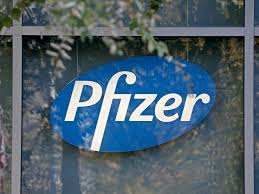

This dataset is about pfizer tweets and we are gonna explore it using  Sentence Transformer !! You can get to know more about sentence transformer from https://github.com/UKPLab/sentence-transformers

# Importing The Packages

In [31]:
import pandas as pd
import numpy as np
from sentence_transformers import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.cm as cm
import torch
import sentence_transformers
from lexrank_utility import *
import umap
import plotly
plotly.offline.init_notebook_mode (connected = True)

# Importing The Data

In [3]:
data=pd.read_csv('../input/pfizer-vaccine-tweets/vaccination_tweets.csv')

In [4]:
data=data[['text']]
df=data.copy()
data.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


# Preprocessing The Data

In [5]:

# Function to preprocess the tweets data
def preprocess_tweet_data(data,name):
    # Lowering the case of the words in the sentences
    data[name]=data[name].str.lower()
    # Code to remove the Hashtags from the text
    data[name]=data[name].apply(lambda x:re.sub(r'\B#\S+','',x))
    # Code to remove the links from the text
    data[name]=data[name].apply(lambda x:re.sub(r"http\S+", "", x))
    # Code to remove the Special characters from the text 
    data[name]=data[name].apply(lambda x:' '.join(re.findall(r'\w+', x)))
    # Code to substitute the multiple spaces with single spaces
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
    # Code to remove all the single characters in the text
    data[name]=data[name].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
    # Remove the twitter handlers
    data[name]=data[name].apply(lambda x:re.sub('@[^\s]+','',x))
# This function is to remove stopwords from a particular column and to tokenize it
def rem_stopwords_tokenize(data,name):

    def getting(sen):
        example_sent = sen

        stop_words = set(stopwords.words('english')) 

        word_tokens = word_tokenize(example_sent) 

        filtered_sentence = [w for w in word_tokens if not w in stop_words] 

        filtered_sentence = [] 

        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w.lower()) 
        return filtered_sentence
    x=[]
    for i in data[name].values:
        x.append(getting(i))
    data[name]=x
# Making a function to lemmatize all the words
lemmatizer = WordNetLemmatizer() 
def lemmatize_all(data,name):
    arr=data[name]
    a=[]
    for i in arr:
        b=[]
        for j in i:
            x=lemmatizer.lemmatize(j,pos='a')
            x=lemmatizer.lemmatize(x)
            b.append(x)
        a.append(b)
    data[name]=a
# Function to make it back into a sentence 
def make_sentences(data,name):
    data[name]=data[name].apply(lambda x:' '.join([i+' ' for i in x]))
    # Removing double spaces if created
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [6]:
# Using the preprocessing function to preprocess the tweet data
preprocess_tweet_data(data,'text')
# Using tokenizer and removing the stopwords
rem_stopwords_tokenize(data,'text')
# Converting all the texts back to sentences
make_sentences(data,'text')

# Importing a pre-trained model from Sentence Transformer

In [7]:
# Getting a model
model=SentenceTransformer('bert-large-nli-mean-tokens')

100%|██████████| 1.24G/1.24G [00:51<00:00, 24.0MB/s] 


# Encodinng The Preprocessed text data

In [8]:
embeddings = model.encode(data['text'])

# Applying K-Means Clustering

## Finding Optimal Clusters For The K-Means Algorithm 

In [11]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=256, batch_size=512, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


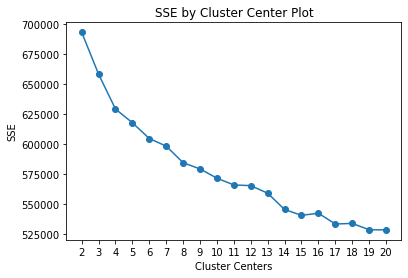

In [12]:
find_optimal_clusters(embeddings, 20)


> **We can see that the highest fall in the SSE was from 2-3 which means the most optimal cluster size is 2 but here we are gonna try with both 2 and 3** 

In [13]:
clusters_2 = MiniBatchKMeans(n_clusters=2, init_size=1024, batch_size=2048, random_state=20).fit_predict(embeddings)

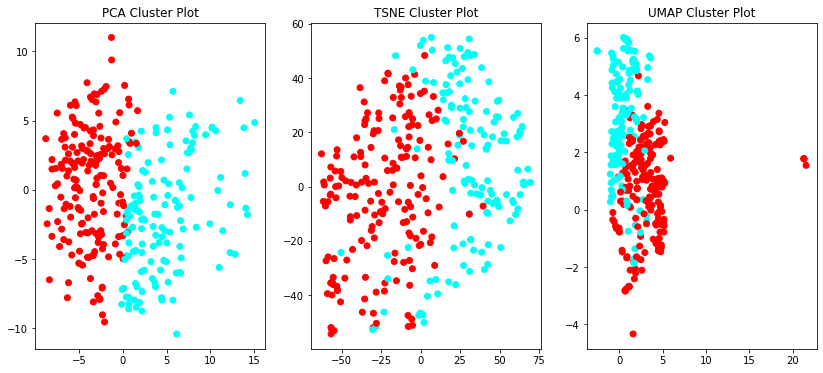

In [14]:
def plot_tsne_pca_umap(data, labels):
    max_label = max(labels)+1
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    reducer=umap.UMAP()
    pca = PCA(n_components=2).fit_transform(data[max_items,:])
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:]))
    uma=reducer.fit_transform(PCA(n_components=50).fit_transform(data[max_items,:]))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=320, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 3, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
    ax[2].scatter(uma[idx,0],uma[idx,1],c=label_subset)
    ax[2].set_title('UMAP Cluster Plot')
    
plot_tsne_pca_umap(embeddings, clusters_2)

Even TSNE is able to differentiate the data in 50 dimensions

In [15]:
clusters_3 = MiniBatchKMeans(n_clusters=3, init_size=1024, batch_size=2048, random_state=20).fit_predict(embeddings)

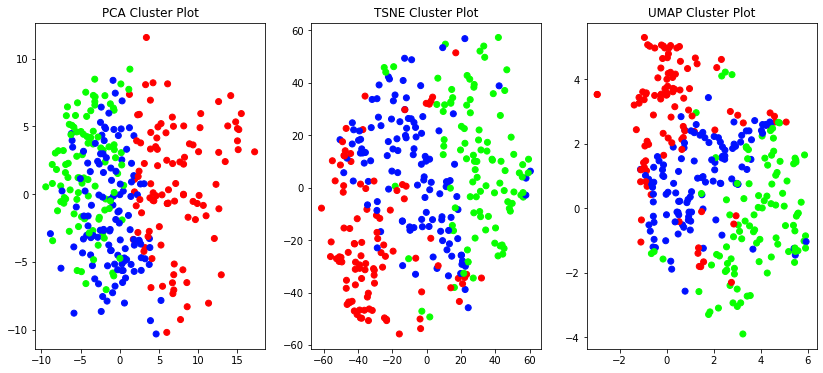

In [16]:
plot_tsne_pca_umap(embeddings, clusters_3)

# Difference between UMAP and TSNE :

#### The main difference between t-SNE and UMAP is the interpretation of the distance between objects or "clusters". 

#### t-SNE preserves local structure in the data.

#### UMAP claims to preserve both local and most of the global structure in the data.

#### UMAP is faster than tSNE when it concerns 
*  large number of data points
*  number of embedding dimensions greater than 2 or 3
*  large number of ambient dimensions in the data set.

# Getting Topics Using BERTopic and Sentence Transformer Embeddings

In [25]:
# There might be some problem with working with matplotlib if you install this package at the start
!pip install --upgrade bertopic[visualization]

     |████████████████████████████████| 301 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 155 kB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 0.14.1
    Uninstalling joblib-0.14.1:
      Successfully uninstalled joblib-0.14.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.1
    Uninstalling matplotlib-3.2.1:
      Successfully uninstalled matplotlib-3.2.1


In [47]:
from bertopic import BERTopic

In [86]:
model2 = BERTopic(language="english")
topics, probabilities = model2.fit_transform(data['text'],embeddings)

> **After generating topics and their probabilities, we can access the frequent topics that were generated:**

In [87]:
model2.get_topic_freq().head()

,Topic,Count
0,-1,1331
1,34,167
2,50,143
3,57,97
4,15,89


#### Here the outliers are labelled as -1 in the topic column

In [88]:
model2.get_topic(24)

[('2nd', 0.13380467431792006),
 ('delighted', 0.09547224092997958),
 ('vaccine', 0.09058304122909024),
 ('thankful', 0.05817332604071877),
 ('covid19', 0.05732765782791232),
 ('science', 0.04975325125695378),
 ('wassmooth', 0.04858865631032583),
 ('wondelay', 0.04858865631032583),
 ('baptisthealthsa', 0.04858865631032583),
 ('youfeel', 0.04858865631032583)]

In [89]:
model2.visualize_topics()

#### Since the first topic was -1 which is represented for outliers i ignored it and looked for topic 31

## Visualizing the distribution of these topics with the help of probability

This only works on one document at a time so we are seeing the probability of a topic in a doc at a time

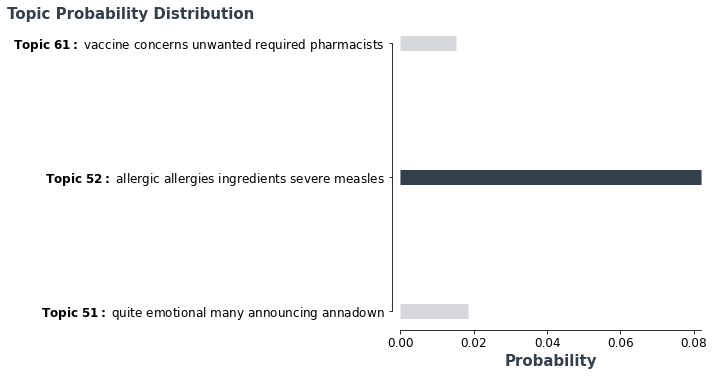

In [90]:
model2.visualize_distribution(probabilities[0])


## Well we can see the highest probability topic in the data is about if there are any allergic reaction to the vaccine to know if there are any side effects to the vaccine .

## After using the n grams model we can see that the topics have words like "allergic" and "allergic reaction" 

## We can also update the topic representation with using n grams

In [91]:
model2.update_topics(data['text'], topics, n_gram_range=(1, 2))

In [92]:
topics, probabilities = model2.fit_transform(data['text'])


# Visualization After Modifications

In [93]:
model2.visualize_topics()

> **From this we can see the largest blob shows that the topics in it are proud , thankfull ,etc. which shows the positive tweets for the new pfizer vaccination . The second largest blob is about the topics 2nd pfizer vaccine or 2nd dose of the pfier vaccine :)**

## Topic Probability Distribution of ngrams

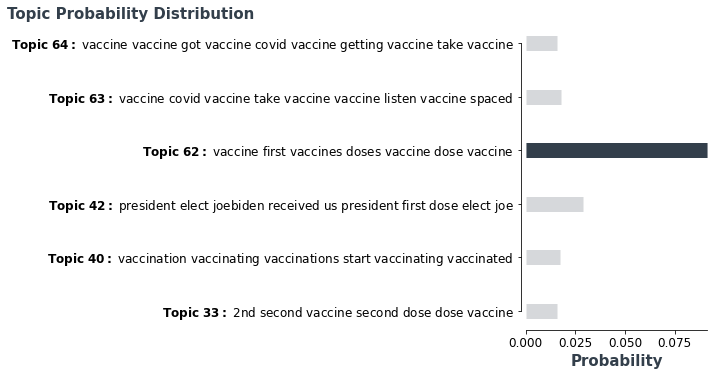

In [102]:
model2.visualize_distribution(probabilities[2])


# out of all the above topics Topic 62 is the one with the highest probability which is all about the first vaccine dose followed by the topic of president joebiden recieving his first dose of pfizer vaccine

# Information Retrieval Using Sentence Transformer

In [21]:
query=input('Enter the query here :')
query_embedding = model.encode(query)

Enter the query here :Is Pfizer really gonna work?


In [22]:
top_k=5
cos_scores = util.pytorch_cos_sim(query_embedding, embeddings)[0]
cos_scores = cos_scores.cpu()

#We use torch.topk to find the highest 5 scores
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", query)
print("\nTop 5 most similar sentences in corpus:")

for score, idx in zip(top_results[0], top_results[1]):
    print(data['text'].values[idx], "(Score: %.4f)" % (score))





Query: Is Pfizer really gonna work?

Top 5 most similar sentences in corpus:
unsure recent approval infographic help  (Score: 0.7135)
shot may defeat new variants study shows  (Score: 0.7125)
vonderleyen pfizer could stop  (Score: 0.7061)
may come risks thank pfizer pfizercongress  (Score: 0.7050)
jab canyour questions answered  (Score: 0.6964)


## Amazing right !!!! I loved these results :)

## What if i say there is a function to use this directly awesome right :)

In [23]:
t=sentence_transformers.util.semantic_search(query_embedding, embeddings, query_chunk_size=200, corpus_chunk_size = 100000, top_k = 10)
idd=[]
score=[]
for i in t[0]:
    idd.append(i['corpus_id'])
    score.append(i['score'])
print("\n\n======================\n\n")
print("Query:", query)
print("\nTop 10 most similar sentences in corpus:")

for score, idx in zip(score,idd):
    print(data['text'].values[idx], "(Score: %.4f)" % (score))





Query: Is Pfizer really gonna work?

Top 10 most similar sentences in corpus:
unsure recent approval infographic help  (Score: 0.7135)
shot may defeat new variants study shows  (Score: 0.7125)
vonderleyen pfizer could stop  (Score: 0.7061)
may come risks thank pfizer pfizercongress  (Score: 0.7050)
jab canyour questions answered  (Score: 0.6964)
jab canyour questions answered  (Score: 0.6964)
jab canyour questions answered  (Score: 0.6964)
matthancock decision delay second dose may backfire pfizer  (Score: 0.6962)
releasedpositive analysis thesingle dose might enough prevent si  (Score: 0.6944)
istill unsure whether notwill vaccine  (Score: 0.6802)


# Text summarization

In [24]:
#Compute the pair-wise cosine similarities
cos_scores = util.pytorch_cos_sim(embeddings, embeddings).numpy()

#Compute the centrality for each sentence
centrality_scores = degree_centrality_scores(cos_scores, threshold=None)

#We argsort so that the first element is the sentence with the highest score
most_central_sentence_indices = np.argsort(-centrality_scores)


#Print the 5 sentences with the highest scores
print("\n\nSummary:")
for idx in most_central_sentence_indices[0:5]:
    print(df['text'][idx].strip())



Summary:
Official @MHRAgovuk statement on use of the #PfizerBioNTech vaccine in those with history of anaphylaxis - good new… https://t.co/Kd1JpgUeVs
V * A * C* C * I * N * A * T* E*D 💉💃💃💃

I recieved my first dose of the pfizer covid vaccine today and I am feeling… https://t.co/RKn5VRSUAJ
Annalise , a nurse from the PAT service received  her Covid Vaccine today at St Richards Hospital. ‘What an efficie… https://t.co/Y4jvGpJKA3
My Grandad is getting the first part of the #PfizerBioNTech #COVID19 vaccine tomorrow. 

—a great scientific achiev… https://t.co/5IBdSGcOtK
I got my first dose of the Covid vaccine today! Doing my part to stop the spread so we can move on from this mess.… https://t.co/qLQC7xO08m


Summary is basically about the people showing their sentiments  after getting their first vaccination of pfizer ever . We can see that most of these statements are positive and people are feeling great about this vaccination .

# Thank you :)
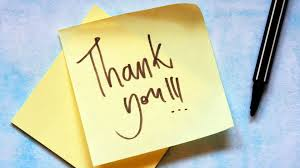